In [1]:
import pickle 
def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

In [2]:
# !ls cifar-10-batches-py/

In [26]:
import numpy as np

def clean(data):
    imgs = data.reshape(data.shape[0],3,32,32)
    grayscale_imgs = imgs.mean(1)
    cropped_imgs = grayscale_imgs[:, 4:28, 4:28]
    img_data = cropped_imgs.reshape(data.shape[0], -1)
    img_size = np.shape(img_data)[1]
    means = np.mean(img_data, axis = 1)
    meansT = means.reshape(len(means), 1)
    stds = np.std(img_data, axis = 1)
    stdsT = stds.reshape(len(stds), 1)
    adj_stds = np.maximum(stdsT, 1.0/np.sqrt(img_size))
    normalized = (img_data - meansT) / adj_stds
    return normalized

In [27]:
def read_data(directory):
    names = unpickle('{}/batches.meta'. format(directory))['label_names']
    print('names', names)
    
    data,labels = [], []
    for i in range(1,6):
        filename = '{}/data_batch_{}'.format(directory, i)
        batch_data = unpickle(filename)
        if len(data) > 0:
            data = np.vstack((data, batch_data['data']))
            labels = np.hstack((labels, batch_data['labels']))
        else:
            data = batch_data['data']
            labels = batch_data['labels']
        print(np.shape(data), np.shape(labels))
        
        data = clean(data)
        data = data.astype(np.float32)
        return names, data, labels

In [6]:
names, data, labels = read_data('dataset/cifar-10-batches-py')
labels = np.array(labels)

names ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(10000, 3072) (10000,)


In [7]:
print(names)
print(data.shape)
print(labels.shape)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(10000, 576)
(10000,)


In [8]:
# visualisasi
import matplotlib.pyplot as plt
import random 
def show_some_examples(names, data, labels):
    plt.figure()
    rows, cols = 2, 2
    random_idxs = random.sample(range(len(data)), rows * cols)
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        j = random_idxs[i]
        plt.title(names[labels[j]])
        img = np.reshape(data[j, :], (24,24))
        plt.imshow(img, cmap='Greys_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('cifar_examples.png')

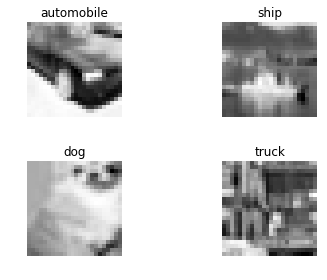

In [9]:
show_some_examples(names, data, labels)

In [10]:
# generate and visualize random filters
import tensorflow as tf
W = tf.Variable(tf.random_normal([5,5,1,32]))
def show_weights(W, filename=None):
    plt.figure()
    rows, cols = 4,8
    for i in range(np.shape(W)[3]):
        img = W[:, :, 0, i]
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='Greys_r', interpolation='none')
        plt.axis('off')
    if filename:
        plt.savefig(filename)
    else:
        plt.show()


/home/jupyterlab/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


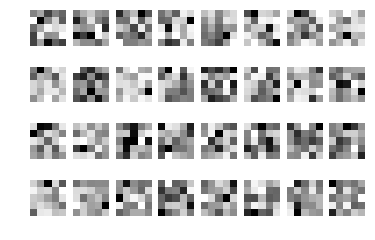

In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    W_val = sess.run(W)
    show_weights(W_val, 'step0_weights.png')

In [28]:
def show_conv_results(data, filename=None):
    plt.figure()
    rows, cols = 4, 8
    for i in range(np.shape(data)[3]):
        img = data[0, :, :, i]
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='Greys_r', interpolation='none')
        plt.axis('off')
    if filename:
        plt.savefig(filename)
    else:
        plt.show()

(1, 24, 24, 32)
(1, 24, 24, 32)


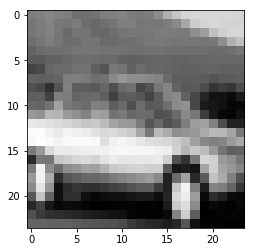

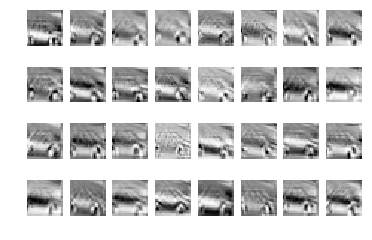

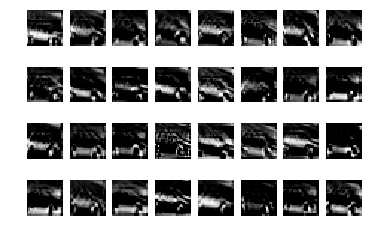

In [13]:
raw_data = data[4, :]
raw_img = np.reshape(raw_data, (24,24))
plt.figure()
plt.imshow(raw_img, cmap='Greys_r')
plt.savefig('input_image.png')

x = tf.reshape(raw_data, shape=[-1,24,24,1])
b = tf.Variable(tf.random_normal([32]))
conv = tf.nn.conv2d(x, W, strides = [1,1,1,1], padding='SAME')
conv_with_b = tf.nn.bias_add(conv, b)
conv_out = tf.nn.relu(conv_with_b)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    conv_val = sess.run(conv)
    show_conv_results(conv_val, 'step1_convs.png')
    print(np.shape(conv_val))
    
    conv_out_val = sess.run(conv_out)
    show_conv_results(conv_out_val, 'step2_conv_outs.png')
    print(np.shape(conv_out_val))

In [ ]:
# maxpooling
# sess.run(tf.global_variables_initializer())
k = 2
maxpool = tf.nn.max_pool(conv_out, 
                        ksize=[1, k, k, 1],
                        strides=[1, k, k, 1],
                        padding='SAME')
with tf.Session() as sess:
    maxpool_val = sess.run(maxpool)
    show_conv_results(maxpool_val, 'step3_maxpool.png')
    print(np.shape(maxpool_val))

## TRAINING

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [16]:
x = tf.placeholder(tf.float32, [None, 24 * 24])
y = tf.placeholder(tf.float32, [None, len(names)])

W1 = tf.Variable(tf.random_normal([5,5,1,64]))
b1 = tf.Variable(tf.random_normal([64]))

W2 = tf.Variable(tf.random_normal([5,5,64,64]))
b2  = tf.Variable(tf.random_normal([64]))

W3 = tf.Variable(tf.random_normal([6*6*64, 1024]))
b3 = tf.Variable(tf.random_normal([1024]))

W_out = tf.Variable(tf.random_normal([1024, len(names)]))
b_out = tf.Variable(tf.random_normal([len(names)]))

In [17]:
def conv_layer(x, W, b):
    conv = tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')
    conv_with_b = tf.nn.bias_add(conv, b)
    conv_out = tf.nn.relu(conv_with_b)
    return conv_out

In [18]:
def maxpool_layer(conv, k=2):
    maxpool = tf.nn.max_pool(conv, ksize=[1,k,k,1], strides=[1,k,k,1], padding='SAME')
    return maxpool

In [19]:
def model():
    x_reshaped = tf.reshape(x, shape=[-1, 24, 24, 1])
    conv_out1 = conv_layer(x_reshaped, W1, b1)
    maxpool_out1 = maxpool_layer(conv_out1)
    norm1 = tf.nn.lrn(maxpool_out1, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)
    
    conv_out2 = conv_layer(norm1, W2, b2)
    norm2 = tf.nn.lrn(conv_out2, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)
    maxpool_out2 = maxpool_layer(norm2)
    
    maxpool_reshaped = tf.reshape(maxpool_out2, [-1, W3.get_shape().as_list()[0]])
    local = tf.add(tf.matmul(maxpool_reshaped, W3), b3)
    local_out = tf.nn.relu(local)
    
    out = tf.add(tf.matmul(local_out, W_out), b_out)
    return out

In [20]:
model_OP = model()

In [21]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model_OP, labels=y))
train_OP = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
correct_pred = tf.equal(tf.argmax(model_OP, 1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    onehot_labels = tf.one_hot(labels, len(names), on_value=1., off_value=0., axis=-1)
    onehot_vals = sess.run(onehot_labels)
    batch_size = len(data) // 200
    print('batch size', batch_size)
    for j in range(0, 10):
        print('EPOCH', j)
        for i in range(0, len(data), batch_size):
            batch_data = data[i:i+batch_size, :]
            batch_onehot_vals = onehot_vals[i:i+batch_size, :]
            out,_, accuracy_val = sess.run([model_OP,train_OP, accuracy], feed_dict={x:batch_data, y:batch_onehot_vals})
            if i % 1000 == 0:
                print(i, accuracy_val)
        print('DONE WITH EPOCH')

In [37]:
pred = np.argmax(out, axis = 1)

In [104]:
def pred_label(y_pred, label_names):
    p = {}
    for i,j in zip(range(len(label_names)), label_names):
        p.update({i:j})
    pp = []
    for i in y_pred:
        pp.append(p[i])
    return pp

In [ ]:
pred_label(pred, names)

In [114]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(labels[:len(pred)], pred))
print(classification_report(labels[:len(pred)], pred))

[[1 0 0 0 1 0 1 1 0 0]
 [0 0 1 1 0 0 1 1 0 2]
 [0 0 1 1 0 1 3 1 1 0]
 [1 1 2 0 3 1 0 0 0 0]
 [1 0 0 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 1 0 0 1]
 [2 0 0 0 0 0 2 1 0 0]
 [0 1 3 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [1 0 0 1 0 0 1 2 1 0]]
             precision    recall  f1-score   support

          0       0.17      0.25      0.20         4
          1       0.00      0.00      0.00         6
          2       0.14      0.12      0.13         8
          3       0.00      0.00      0.00         8
          4       0.20      0.20      0.20         5
          5       0.00      0.00      0.00         2
          6       0.18      0.40      0.25         5
          7       0.00      0.00      0.00         5
          8       0.00      0.00      0.00         1
          9       0.00      0.00      0.00         6

avg / total       0.07      0.10      0.08        50

